In [1]:
ENV["GKS_ENCODING"]="utf8"

using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots
using ColorSchemes
using Random
using StatsPlots
using LinearAlgebra

In [2]:
Random.seed!(125)

L         = 50.0
nmixtures = 12
n_samples = 500

probvec = ones(nmixtures)
probvec = probvec ./ sum(probvec)

switch = Categorical(probvec)

println("Switch distribution: ", params(switch))

gaussians = map(1:nmixtures) do index
    angle      = 2π / nmixtures * (index - 1)
    basis_v    = L * [ 1.0, 0.0 ]
    rotationm  = [ cos(angle) -sin(angle); sin(angle) cos(angle) ]
    mean       = rotationm * basis_v 
    covariance = Matrix(Hermitian(rotationm * [ 100.0 0.0; 0.0 1.0 ] * transpose(rotationm)))
    return MvNormal(mean, covariance)
end

z = rand(switch, n_samples)
y = Vector{Vector{Float64}}(undef, n_samples)

for i in 1:n_samples
    y[i] = rand(gaussians[z[i]])
end

colors  = palette(:tab10);

Switch distribution: ([0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333],)


In [3]:
sdim(n) = (a) -> map(d -> d[n], a)

sdim (generic function with 1 method)

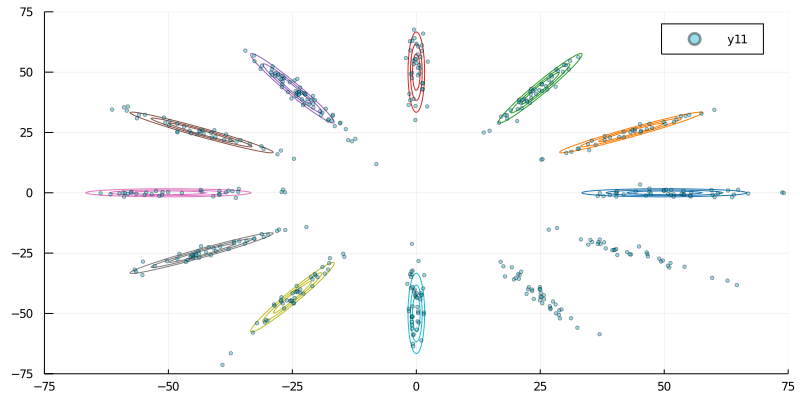

In [4]:
p = plot(xlim = (-1.5L, 1.5L), ylim = (-1.5L, 1.5L))

for (index, (color, gaussian)) in enumerate(zip(colors, gaussians))
    p = contour!(p, range(-2L, 2L, step = 0.25), range(-2L, 2L, step = 0.25), (x, y) -> pdf(gaussian, [ x, y ]), levels = 3, colorbar = false, color = color)
end

p = scatter!(y |> sdim(1), y |> sdim(2), ms = 2, alpha = 0.4)

plot(p, size = (800, 400))

In [5]:
@model function gaussian_mixture_model(nmixtures, n)
    
    z = randomvar(n)
    m = randomvar(nmixtures)
    w = randomvar(nmixtures)
    
    L       = 50.0
    basis_v = L * [ 1.0, 0.0 ]
    
    for i in 1:nmixtures
        angle_prior = (2π / nmixtures) * (i - 1)
        mean_mean_prior = [ cos(angle_prior) -sin(angle_prior); sin(angle_prior) cos(angle_prior) ] * basis_v
        mean_mean_cov   = [ 1e6 0.0; 0.0 1e6 ]
        
        m[i] ~ MvNormalMeanCovariance(mean_mean_prior, mean_mean_cov)
        w[i] ~ Wishart(2, [ 1e5 0.0; 0.0 1e5 ])
    end
    
    s ~ Dirichlet(ones(nmixtures))

    y = datavar(Vector{Float64}, n)
    
    means = tuple(m...)
    precs = tuple(w...)
    
    for i in 1:n
        z[i] ~ Categorical(s) where { q = MeanField() }
        y[i] ~ NormalMixture(z[i], means, precs) where { q = MeanField() }
    end
    
    return s, z, m, w, y
end

gaussian_mixture_model (generic function with 1 method)

In [9]:
import ProgressMeter

function inference(nmixtures, data, viters)
    n = length(data)
    
    model, (s, z, m, w, y) = gaussian_mixture_model(nmixtures, n)
    
    means_estimates  = Vector{Vector{Marginal}}()
    precs_estimates  = Vector{Vector{Marginal}}()
    switch_estimates = Vector{Marginal}()
    fe_values        = Vector{Float64}()

    switch_subscription = subscribe!(getmarginal(s), (m) -> push!(switch_estimates, m))
    means_subscription  = subscribe!(getmarginals(m), (m) -> push!(means_estimates, m))
    precs_subscription  = subscribe!(getmarginals(w), (m) -> push!(precs_estimates, m))
    fe_subscription     = subscribe!(score(BetheFreeEnergy(), model), (fe) -> push!(fe_values, fe))
    
    setmarginal!(s, vague(Dirichlet, nmixtures))
    
    basis_v = [ 1.0, 0.0 ]
    
    for i in 1:nmixtures
        angle_prior = (2π / nmixtures) * (i - 1)
        mean_mean_prior = [ cos(angle_prior) -sin(angle_prior); sin(angle_prior) cos(angle_prior) ] * basis_v
        mean_mean_cov   = [ 1e6 0.0; 0.0 1e6 ]
        
        setmarginal!(m[i], MvNormalMeanCovariance(mean_mean_prior, mean_mean_cov))
        # setmarginal!(m[i], vague(MvNormalMeanCovariance, 2))
        setmarginal!(w[i], Wishart(2, [ 1e3 0.0; 0.0 1e3 ]))
    end
    
    ProgressMeter.@showprogress for i in 1:viters
        update!(y, data)
    end
    
    unsubscribe!(means_subscription)
    unsubscribe!(precs_subscription)
    unsubscribe!(switch_subscription)
    unsubscribe!(fe_subscription)
    
    return switch_estimates, means_estimates, precs_estimates, fe_values
end

inference (generic function with 1 method)

In [12]:
s, m, w, fe = inference(nmixtures, y, 15);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


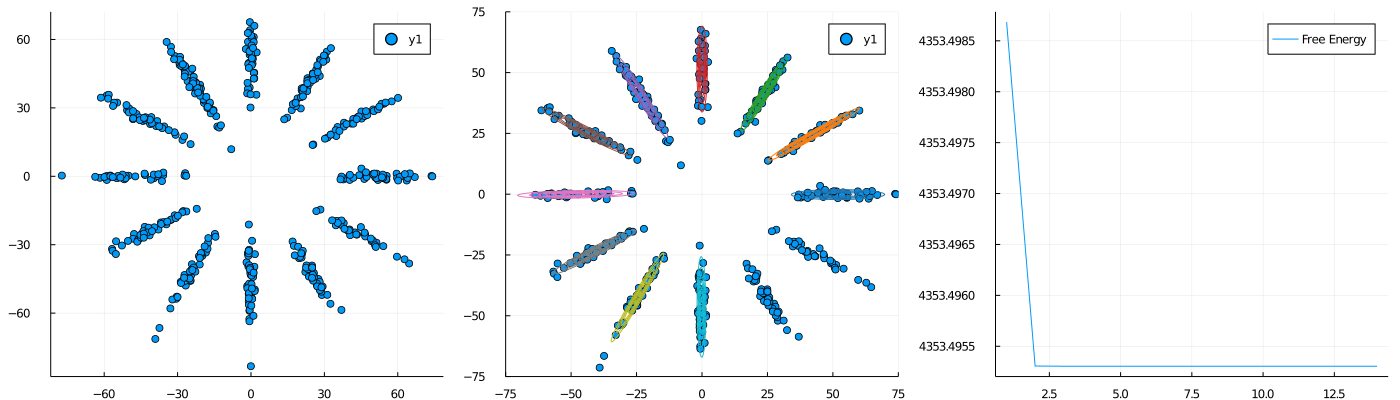

In [13]:
pe = plot(xlim = (-1.5L, 1.5L), ylim = (-1.5L, 1.5L))

rp = scatter(y |> sdim(1), y |> sdim(2))

pe = scatter!(pe, y |> sdim(1), y |> sdim(2))

e_means = mean.(m[end])
e_precs = mean.(w[end])

for (e_m, e_w, c) in zip(e_means, e_precs, colors)
    gaussian = MvNormal(e_m, Matrix(Hermitian(inv(e_w))))
    pe = contour!(pe, range(-2L, 2L, step = 0.25), range(-2L, 2L, step = 0.25), (x, y) -> pdf(gaussian, [ x, y ]), levels = 7, colorbar = false, color = c)
end

pfe = plot(fe[2:end], label = "Free Energy")

plot(rp, pe, pfe, size = (1400, 400), layout = @layout([ a b c ]))